# CS224 - Spring 2024 - HW2 - Deepfake Cat Detector
Submit **PDF** of completed IPython notebook on Canvas

**Due**: February 22, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Joseph Mangapit
  </br>
  <b>Student ID Number</b>:  862175676
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview 
In this assignment you will implement some classifiers to predict whether or not images of cats are "deepfakes", i.e., generated by AI. (I used SD 1.5, and down-sampled to match CIFAR-10, which we use for real images.) 

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, scikit-learn (for cross validation utility and for baseline logistic regression), matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed). 

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the parts marked `TODO` and print desired results. (In some cases, this just means getting the code to work so the TODO section prints the correct result.) 

In [1]:
import torch
# The following functions were discussed in week 4 demo
import torch.nn as nn  # neural net layers and activations
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset  # Super useful data utilities!

# We discussed all these in week 3 demo: 
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Used for visualization
import torchvision.utils as vutils
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# Turn off some annoying convergence warnings from sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## **Obtain and inspect data [3 points]**
You can download the data file here:
 https://elearn.ucr.edu/courses/125165/files/12619307/download?download_frd=1
You'll have to make them available locally or upload them to your colab instance.

Data shapes before flattening:
X: torch.Size([2000, 3, 32, 32])
y: torch.Size([2000])
X shape after flattening: torch.Size([2000, 3072])



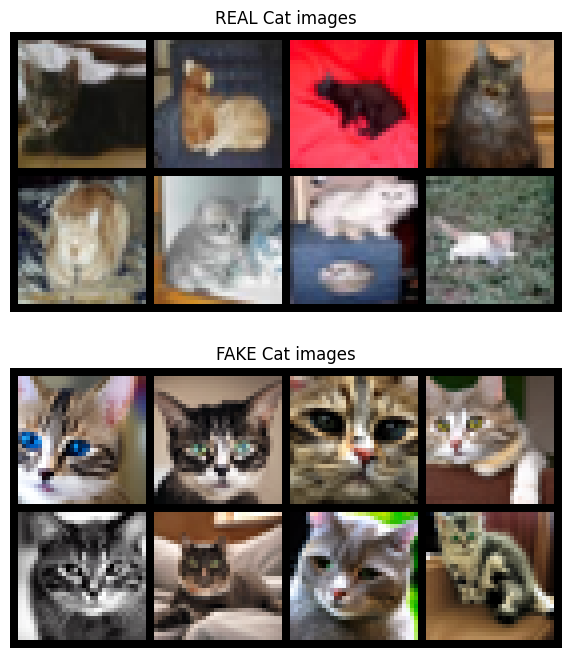

In [2]:
# Load dataset and visualize
X, y = torch.load('hw2_data.pt')

print('Data shapes before flattening:')
print('X:', X.shape)  # 2000, 3, 32, 32, 2000 images, channel, height width
print('y:', y.shape)  # 2000 binary labels 0 is real, 1 is fake

# Print examples from each class
grid = vutils.make_grid(X[y==0][:8], nrow=4, padding=2, normalize=True)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].axis('off')
axs[0].set_title('REAL Cat images')
axs[0].imshow(grid.numpy().transpose((1, 2, 0)))

grid = vutils.make_grid(X[y==1][:8], nrow=4, padding=2, normalize=True)
axs[1].axis('off')
axs[1].set_title('FAKE Cat images')
axs[1].imshow(grid.numpy().transpose((1, 2, 0)))


X = X.flatten(start_dim=1)  # From now on, we work with the flattened vector
print(f"X shape after flattening: {X.shape}\n")

In [3]:
# TODO [3 points]: 
# Use scikit-learn logistic regression (with default hyper-parameters) 
# with 5-fold CV to get the train and validation accuracies
# for a simple linear classifier - a good baseline for our MLP
n_folds = 5
val_accs = []  # store validation accuracy for each fold
train_accs = []  # store training accuracy for each fold

# TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled
kf = KFold(n_splits=n_folds, shuffle=True)
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx] #help from lectures, friends, and ChatGPT understand how to utilize the K-Folds
    y_train, y_val = y[train_idx], y[val_idx]
    # TODO: Fit model on training data
    clf = LogisticRegression(C=1.)
    clf.fit(X_train,y_train)
    #print(train_indx,val_idx)
    # TODO: Compute and store accuracy on train data
    predicted_train_label = clf.predict(X_train)
    train_acc = accuracy_score(y_train, predicted_train_label)
    train_accs.append(train_acc)
    
    # TODO: Compute and store accuracy on validation data
    
    predicted_val = clf.predict(X_val)
    val_acc = accuracy_score(y_val, predicted_val)
    val_accs.append(val_acc)

train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
val_std, val_mean = torch.std_mean(torch.tensor(val_accs))

# Standard error is standard deviation / sqrt(n), it is more typical to report this
rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
print(f'Train Accuracy and standard error:\t {train_mean:.3f} +/- {train_std / rootn:.3f}')
print(f'Validation Accuracy and standard error:\t {val_mean:.3f} +/- {val_std / rootn:.3f}')

Train Accuracy and standard error:	 0.985 +/- 0.002
Validation Accuracy and standard error:	 0.623 +/- 0.013


## Define the model [3 points]

- As always, implement an __init__ function and a forward function
- Use Linear layers with ReLU activations for the hidden layers
- 2 layers of hidden units. First layer has 128 hidden units, second layer has 64 hidden units. 
- Output represents *binary* logits (must have correct shape to do that!)

In [4]:
class MyMLP(nn.Module):
    # TODO: Define a multilayer perceptron [3 points]. Criteria above
    def __init__(self):
        super(MyMLP, self).__init__()
        
        self.fc1 = nn.Linear(3072, 128)   #3072 features into 128 hidden units
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)   #128 hidden units into 64 hidden units
        self.fc3 = nn.Linear(64, 2) #2 logits because 2 classes, cat and fake cat
        #self.fc1 = nn.Linear(3072,128)
        #self.fc2 = nn.Linear(128, 64)
        #self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        h1 = self.relu1(self.fc1(x))
        h2 = self.relu1(self.fc2(h1))
        logits = self.fc3(h2)
        #h1 = torch.nn.functional.relu(self.fc1(x)) 
        #h2 = torch.nn.functional.relu(self.fc2(h1))
        #logits = self.fc3(h2)
        return logits
        


In [5]:
model = MyMLP()
model(X)
#list(model.parameters())[5]

tensor([[ 0.2403, -0.0044],
        [ 0.1579, -0.0541],
        [ 0.2157,  0.0614],
        ...,
        [ 0.2130, -0.0112],
        [ 0.1678, -0.0491],
        [ 0.1867, -0.0141]], grad_fn=<AddmmBackward0>)

## Train function [6 points]
Make a function to train your neural net, following week 4 example

In [6]:
# TODO [3 points]: a function to train your model 
# (this will called for each hyper-parameter and fold)
# Don't forget to set model.train() during training, then model.eval() after done
# It doesn't matter in this case, but is good practice to prevent future bugs. 

def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False):
    """Train model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (SGD in this case) 
    and "criterion" as the loss function (CrossEntropyLoss in this case). 
    """
    for _ in range(n_epochs):
        # TODO: Train loop
        for x_batch, y_batch in train_loader:
            model.zero_grad()  # reset gradients
            logits = model(x_batch)
            loss = criterion(logits, y_batch)  # forward pass
            loss.backward()  # backward pass
            optimizer.step()  # implements the gradient descent step
            #print(f'Train Loss: {loss.item():.3f}')
        
        # Validation loop, every k epochs 
        model.eval()  # train vs eval mode   A huge source of bugs
        val_loss = 0.0
        with torch.no_grad():  # no gradients needed not training 
            for x_batch, y_batch in val_loader:
                logits = model(x_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item() / len(val_loader)
        #print(f'Val Loss: {val_loss:.3f}')
        model.train()
        if verbose:
            # Optional: Validation loop
            # Print out train/val loss during development
            # User verbose=False to turn off output of this in the submitted PDF
            print('Validation loss')

Loop over hyper-parameters and do 5-fold cross-validation for each setting, saving the train and validation mean accuracy and standard error.

In [7]:
# TODO [3 points]: Perform cross-validation to get train/val accuracy 
# for all hyper-parameter settings in the list below. 
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01]
batch_size = 50
n_epochs = 100
n_folds = 5

results = []
for lr in learning_rates:
    for wd in weight_decays: 
        val_accs = []  # store validation accuracy for each fold
        train_accs = []  # store training accuracy for each fold
        # TODO: iterate over folds, remember to use "shuffle=True", as datapoints are not shuffled
        kf = KFold(n_splits=n_folds, shuffle=True)

            # TODO: Split data into train and validation
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx] 
            y_train, y_val = y[train_idx], y[val_idx]
            # TODO: Create data loaders to pass to training loop
            train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)  
            val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=True)
            # TODO: Initialize model, criterion (Cross entropy loss), and optimizer (SGD with various hyperparameters)
            model = MyMLP() #model
            criterion = nn.CrossEntropyLoss() #criterion
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)#optimizer

            
            # Call your training function
            train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False)
            #training = torch.Tensor(X_train, y_train)
            #validating = torch.Tensor(X_val, y_val)
            with torch.no_grad():
                # TODO: Use the trained model to estimate train/val accuracy
                # (Hint: our model outputs logits, argmax is good to get the class prediction corresponding to max logit)
                #predicted_t_label = torch.nn.functional.softmax((model.forward(y_train)))
                #torch.nn.functional.softmax(model.forward(X_train), dim=1)
                probs = torch.softmax(model.forward(X_train), dim=1)
                preds = torch.argmax(probs, dim=1)
                
                train_acc = accuracy_score(preds, y_train)
                train_accs.append(train_acc)
                
                probs = torch.softmax(model.forward(X_val), dim =1)
                preds = torch.argmax(probs, dim=1)
                
                val_acc = accuracy_score(preds, y_val)
                val_accs.append(val_acc)

        # For each hyper-parameter, I'm storing the parameter values and the mean and standard error of accuracy in a list in "results". 
        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
        rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
        train_se, val_se = train_std / rootn, val_std / rootn
        # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error 
        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))


In [8]:
train_loader

## Show result [3 points]

In [60]:
# TODO [3 points]. Print the final result (should be no need to modify code)
# You should be able to see a best train acc > 95% , and a best val acc > 80%

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.817 +/- 0.002,0.999 +/- 0.000,1.000 +/- 0.000
0.01,0.806 +/- 0.001,0.999 +/- 0.000,0.998 +/- 0.000


Validation results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.767 +/- 0.006,0.816 +/- 0.004,0.813 +/- 0.010
0.01,0.756 +/- 0.012,0.809 +/- 0.006,0.822 +/- 0.008


## Extra credit

There are some nice opportunities for extra credit, though I will be fairly stingy with the points, so you should only try it if you're interested in learning more.
Some examples of things you could try for 1 extra point.
- Use t-SNE or UMAP to visualize a 2-d embedding of all the points, and see if the real and fake images are separable in the 2-d space.
- Use a more complex vision backbone like a pretrained ResNet to first embed the images, then train your MLP. You'll have to be careful to transform the images before input into a ResNet, as they usually expect a specific resolution. You can use torchvision transforms library for this. Does this increase accuracy? I don't know, but I speculate it won't help much - these embeddings are trained for classification accuracy, so they have no reason to preserve differences that are useful for finding fakes.
- Train a more complex vision backbone, instead of using the MLP. Again, a ResNet or a small vision transformer would be interesting. I think this would be the most typical and effective approach.
- Being an expert at hyper-parameter tuning is a skill that will benefit you greatly. Try a more fancy way to do this, like https://docs.wandb.ai, and see how well you can do on this assigment if you also vary other hyper-parameters (architecture, n_epochs, maybe early stopping, more learning rate/weight decay settings, regularizers, etc.) 

Of course you can train your deepfake detector on my fakes, but how well will it do on ones from some other system? This is the fundamental research question in that field - how to build robust detectors that will work well even on new image generators. 